## Load packages

In [33]:
import numpy as np
import pandas as pd
import math
from keras import optimizers
from keras import layers
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras import callbacks
from numpy import save
import seaborn as sns
sns.set_palette(sns.color_palette("hls", 27))

import keras.backend as K
import tensorflow as tf
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib import pyplot
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import multilabel_confusion_matrix, classification_report

import geopandas as gpd
%matplotlib inline

In [2]:
# set number of cores to 8
# K.set_session(tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=8, 
#                                                    inter_op_parallelism_threads=8)))

## Load dataset

In [3]:
# import Matt's 'chr1_ukb_X.npz' file
chr1_ukb_X = np.load('/home/magu/deepmix/data/ALL_DNA_dataset/chr1_1kg_X.npz')
# create dict mapping from sampleid to population name
sampleid_to_population_pandas_df = pd.read_csv('/home/jsokol/Data/igsr_samples_cleaned_version.tsv', delimiter="\t")
sampleid_to_population_dict = sampleid_to_population_pandas_df.set_index('Sample name')['Population code'].to_dict()
# remove samples from chr1_ukb_X that are not in dict or that do not contain value
temp = set()
for x in np.nditer(chr1_ukb_X['S']):
    sample_id = str((x.item(0))).replace("'", "").replace("b", "").split("_")[0]
    if sample_id not in sampleid_to_population_dict:
        print(sample_id + ' is not in dict. Make sure to remove this sample from the dataset.')
    elif sampleid_to_population_dict[sample_id] == float('nan'):
        print(sample_id + ' maps to nan in dict')
chr1_ukb_X_G = chr1_ukb_X['G'][:,:,:]
chr1_ukb_X_V = chr1_ukb_X['V'][:,:]
# flatten input data
X_all_data = chr1_ukb_X_G.reshape(chr1_ukb_X_G.shape[0], -1).T

In [4]:
# create dict mapping from sample to population
populations_represented_set = set()
for i in range(5008):
    sample_id = str(chr1_ukb_X['S'][i].item(0)).replace("'", "").replace("b", "").split("_")[0]
    populations_represented_set.add(sampleid_to_population_dict[sample_id])
# print total number of populations represented by dataset
n_classes = len(populations_represented_set)
print('Total number of classes minus classes deleted because they are admixed = ' + str(n_classes))
print(populations_represented_set)

Total number of classes minus classes deleted because they are admixed = 26
{'FIN', 'KHV', 'ACB', 'CHS', 'CLM', 'CHB', 'ITU', 'PJL', 'CDX', 'GBR', 'PUR', 'TSI', 'STU', 'YRI', 'PEL', 'ASW', 'CEU', 'ESN', 'BEB', 'GIH', 'JPT', 'GWD', 'MSL', 'MXL', 'IBS', 'LWK'}


In [5]:
# create dict mapping from population to coordinate tuple
pop_info_df=pd.read_csv('/home/jsokol/Data/igsr_population_coordinates.tsv', sep='\t')
pop_info_df['coordinate_tuples'] = tuple(zip(pop_info_df['Population latitude'], pop_info_df['Population longitude']))
pop_to_coordinate_dict = pop_info_df.set_index('Population code')['coordinate_tuples'].to_dict()

In [6]:
# create 'Y_all_data' matrix containing labels
Y_all_data = np.zeros((2, 5008))
indices_to_delete = list()
for i in range(5008):
    sample_id = str(chr1_ukb_X['S'][i].item(0)).replace("'", "").replace("b", "").split("_")[0]
    Y_all_data[0,i] = pop_to_coordinate_dict[sampleid_to_population_dict[sample_id]][0]
    Y_all_data[1,i] = pop_to_coordinate_dict[sampleid_to_population_dict[sample_id]][1]
# delete samples with unwanted classes using 'indices_to_delete'
X_all_data = np.delete(X_all_data, indices_to_delete, 1)
Y_all_data = np.delete(Y_all_data, indices_to_delete, 1)
# rescale the longitudes and latitudes
Y_all_data[1,:] = (Y_all_data[1,:]/180)
Y_all_data[0,:] = (Y_all_data[0,:]/90)

In [7]:
# randomly shuffle the order of the data
randomize = np.arange(X_all_data.shape[1])
np.random.shuffle(randomize)
X_all_data = X_all_data[:,randomize]
Y_all_data = Y_all_data[:,randomize]

In [8]:
# split data into training and test sets
X_train = X_all_data[:,:int(X_all_data.shape[1]*0.8)]
X_test = X_all_data[:,int(X_all_data.shape[1]*0.8):]
Y_train = Y_all_data[:,:int(X_all_data.shape[1]*0.8)]
Y_test = Y_all_data[:,int(X_all_data.shape[1]*0.8):]
# convert to correct format for use in keras
X_train = X_train[:,:,np.newaxis]
X_train = np.transpose(X_train, (1, 0, 2))
X_test = X_test[:,:,np.newaxis]
X_test = np.transpose(X_test, (1, 0, 2))
Y_train = np.transpose(Y_train, (1, 0))
Y_test = np.transpose(Y_test, (1, 0))

## Build model

In [9]:
def model2(n_snps_per_sample):
    """
    input_shape: The height, width and channels as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """
    
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(shape=(n_snps_per_sample, 1))

    # First convolutional block
    X = Conv1D(filters=49, kernel_size=500 ,strides=500, padding = 'valid', name = 'conv0')(X_input)
    X = BatchNormalization(axis = -1, name = 'bn0')(X)
    X = Activation('relu')(X)

    # Second convolutional block
    X = Conv1D(49, 75, strides = 5, padding = 'same', name = 'conv1')(X)
    X = BatchNormalization(axis = -1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # MAXPOOL
    X = MaxPooling1D(2, name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1127, activation='relu')(X)
    X = Dense(20, activation='relu')(X)
    X = Dense(2, activation='tanh', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='model2')
    
    return model

## Create and compile the model 

In [10]:
# create model
model2 = model2(X_train.shape[1])
# compile model
adam_optimizer_fn = optimizers.Adam(lr=0.0001, beta_1=0.99, beta_2=0.999, amsgrad=False)
# haversine loss
def haversine_loss(y, y_hat):
    return tf.math.asin(K.sqrt((K.sin(0.5*(y[:,0]-y_hat[:,0])*np.pi))**2 + K.cos((y[:,0])*np.pi)*K.cos((y_hat[:,0])*np.pi)*(K.sin(0.5*(y[:,1]-y_hat[:,1])*np.pi)**2)))
    
model2.compile(optimizer=adam_optimizer_fn, loss='mean_squared_error', metrics=['mean_squared_error']) 
# summarize model
model2.summary()
print('Learning rate = ' + str(K.eval(model2.optimizer.lr)))

Model: "model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 231504, 1)         0         
_________________________________________________________________
conv0 (Conv1D)               (None, 463, 49)           24549     
_________________________________________________________________
bn0 (BatchNormalization)     (None, 463, 49)           196       
_________________________________________________________________
activation_1 (Activation)    (None, 463, 49)           0         
_________________________________________________________________
conv1 (Conv1D)               (None, 93, 49)            180124    
_________________________________________________________________
bn1 (BatchNormalization)     (None, 93, 49)            196       
_________________________________________________________________
activation_2 (Activation)    (None, 93, 49)            0    

## Train model

In [11]:
es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

history = model2.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 500, batch_size = 1, callbacks = [es])




Train on 4006 samples, validate on 1002 samples
Epoch 1/500
4006/4006 [==============================] - 77s 19ms/step - loss: 0.3682 - mean_squared_error: 0.3682 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 2/500
4006/4006 [==============================] - 76s 19ms/step - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0326 - val_mean_squared_error: 0.0326
Epoch 3/500
4006/4006 [==============================] - 76s 19ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - val_loss: 0.0363 - val_mean_squared_error: 0.0363
Epoch 4/500
4006/4006 [==============================] - 76s 19ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0249 - val_mean_squared_error: 0.0249
Epoch 5/500
4006/4006 [==============================] - 76s 19ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0253 - val_mean_squared_error: 0.0253
Epoch 6/500
4006/4006 [==============================] - 76s 19ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - 

4006/4006 [==============================] - 75s 19ms/step - loss: 3.5435e-04 - mean_squared_error: 3.5435e-04 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoch 49/500
4006/4006 [==============================] - 76s 19ms/step - loss: 3.6426e-04 - mean_squared_error: 3.6425e-04 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoch 50/500
4006/4006 [==============================] - 75s 19ms/step - loss: 3.1260e-04 - mean_squared_error: 3.1260e-04 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 51/500
4006/4006 [==============================] - 75s 19ms/step - loss: 3.0057e-04 - mean_squared_error: 3.0057e-04 - val_loss: 0.0165 - val_mean_squared_error: 0.0165
Epoch 52/500
4006/4006 [==============================] - 75s 19ms/step - loss: 2.6632e-04 - mean_squared_error: 2.6632e-04 - val_loss: 0.0163 - val_mean_squared_error: 0.0163
Epoch 53/500
4006/4006 [==============================] - 76s 19ms/step - loss: 2.8609e-04 - mean_squared_error: 2.8609e-04 - val_los

4006/4006 [==============================] - 75s 19ms/step - loss: 1.2480e-04 - mean_squared_error: 1.2480e-04 - val_loss: 0.0165 - val_mean_squared_error: 0.0165
Epoch 95/500
4006/4006 [==============================] - 75s 19ms/step - loss: 1.0895e-04 - mean_squared_error: 1.0895e-04 - val_loss: 0.0165 - val_mean_squared_error: 0.0165
Epoch 96/500
4006/4006 [==============================] - 75s 19ms/step - loss: 1.0994e-04 - mean_squared_error: 1.0994e-04 - val_loss: 0.0172 - val_mean_squared_error: 0.0172
Epoch 97/500
4006/4006 [==============================] - 76s 19ms/step - loss: 1.1867e-04 - mean_squared_error: 1.1867e-04 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoch 98/500
4006/4006 [==============================] - 75s 19ms/step - loss: 1.0023e-04 - mean_squared_error: 1.0023e-04 - val_loss: 0.0164 - val_mean_squared_error: 0.0164
Epoch 99/500
4006/4006 [==============================] - 75s 19ms/step - loss: 1.0351e-04 - mean_squared_error: 1.0351e-04 - val_los

4006/4006 [==============================] - 75s 19ms/step - loss: 7.4205e-05 - mean_squared_error: 7.4205e-05 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 141/500
4006/4006 [==============================] - 75s 19ms/step - loss: 7.6032e-05 - mean_squared_error: 7.6032e-05 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 142/500
4006/4006 [==============================] - 75s 19ms/step - loss: 7.4348e-05 - mean_squared_error: 7.4348e-05 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 143/500
4006/4006 [==============================] - 75s 19ms/step - loss: 6.4723e-05 - mean_squared_error: 6.4723e-05 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 144/500
4006/4006 [==============================] - 75s 19ms/step - loss: 6.7090e-05 - mean_squared_error: 6.7090e-05 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 145/500
4006/4006 [==============================] - 75s 19ms/step - loss: 6.3182e-05 - mean_squared_error: 6.3182e-05 - va

KeyboardInterrupt: 

In [ ]:
# 1) create loss and accuracy plots
_, train_acc = model2.evaluate(X_train, Y_train, verbose=0)
_, test_acc = model2.evaluate(X_test, Y_test, verbose=0)
# 1.1) plot loss during training
pyplot.figure(1, (9,9))
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
print('train mse:', train_acc)
print('test mse:', test_acc)

In [13]:
# re-scale longitudes and latitudes
Y_pred = model2.predict(X_test, verbose=1)
Y_test[:,1] = Y_test[:,1]*180 
Y_test[:,0] = Y_test[:,0]*90
Y_pred[:,1] = Y_pred[:,1]*180
Y_pred[:,0] = Y_pred[:,0]*90

1002/1002 [==============================] - 1s 1ms/step


In [19]:
Y_pred2 = model2.predict(X_train, verbose=1)
Y_train[:,1] = Y_train[:,1]*180 
Y_train[:,0] = Y_train[:,0]*90
Y_pred2[:,1] = Y_pred2[:,1]*180
Y_pred2[:,0] = Y_pred2[:,0]*90

4006/4006 [==============================] - 5s 1ms/step


In [17]:
# display a sample of predictions and ground truths 
np.set_printoptions(suppress=True) # to suppress numbers being displayed in scientific notation
print('Sample ground truths: ')
print(Y_test)
print(' ')
print('Sample predictions: ')
print(Y_pred)

Sample ground truths: 
[[ 42.1       12.      ]
 [ 13.1      -59.62    ]
 [  9.06666    7.483333]
 ...
 [ 31.554606  74.357158]
 [ -1.27      36.61    ]
 [ 52.486243  -1.890401]]
 
Sample predictions: 
[[ 37.14583     3.5697997]
 [ 12.1153755 -14.9607935]
 [  9.150286   -0.7446132]
 ...
 [ 26.600918   65.96935  ]
 [  5.289696    9.763765 ]
 [ 40.454674  -15.827148 ]]


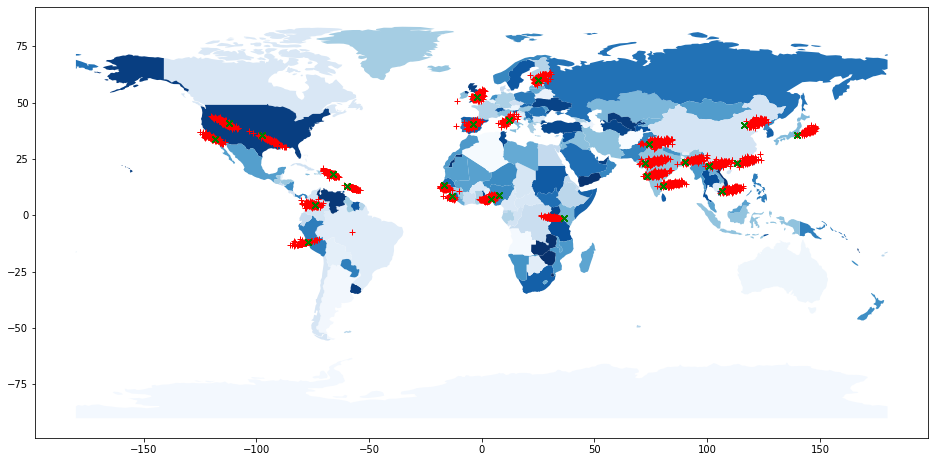

In [39]:
# generate map with ground truth labels and predictions of train set
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# centroids = world.centroid
# centroid_list = pd.concat([world.name, centroids], axis=1)
# Plot the results
base = world.plot(column='name', cmap='Blues', figsize=(16,8))
base.plot(Y_pred2[:,1], Y_pred2[:,0], 'r+')
base.plot(Y_train[:,1], Y_train[:,0], 'gx')
# centroids.plot(ax = base, marker = 'o', color = 'red', markersize = 5)

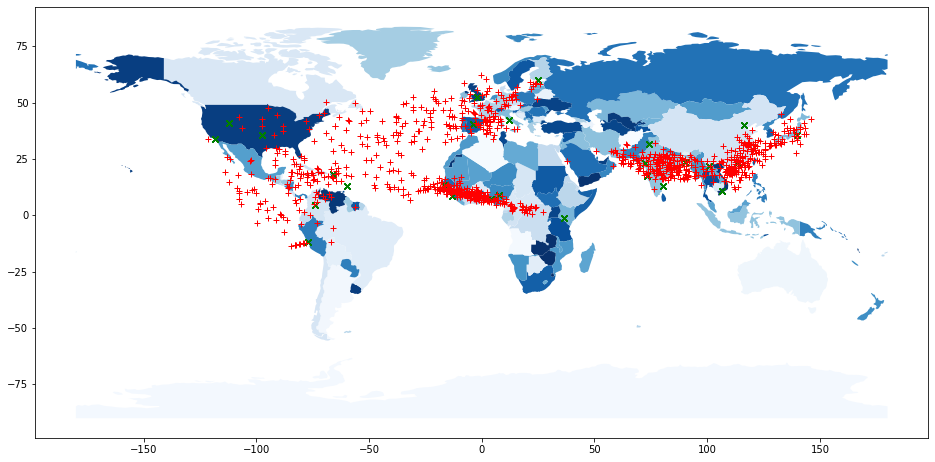

In [21]:
# generate map with ground truth labels and predictions of test set
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# centroids = world.centroid
# centroid_list = pd.concat([world.name, centroids], axis=1)
# Plot the results
base = world.plot(column='name', cmap='Blues', figsize=(16,8))
base.plot(Y_test[:,1], Y_test[:,0], 'gx')
base.plot(Y_pred[:,1], Y_pred[:,0], 'r+')
# centroids.plot(ax = base, marker = 'o', color = 'red', markersize = 5)

Text(0.5, 1, 'Coordinate predictions on train set')

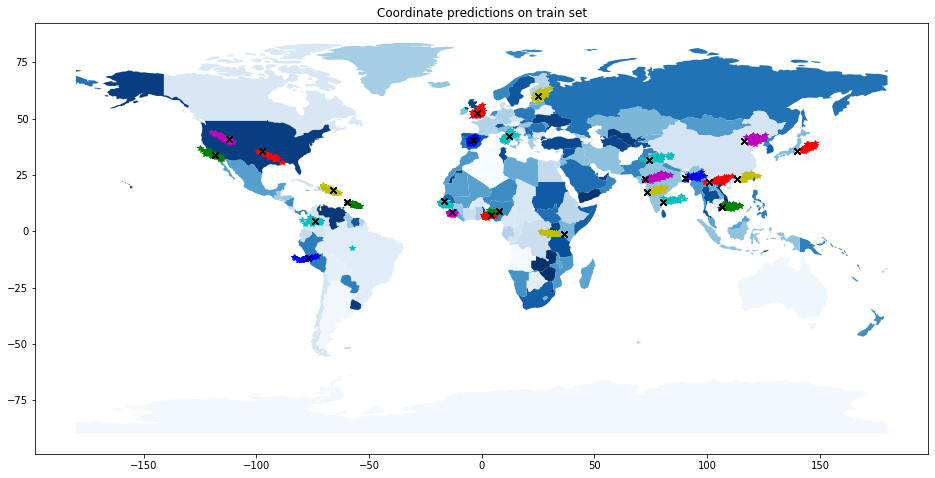

In [61]:
# generate map with ground truth labels and predictions color coded by ground truth labels
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(column='name', cmap='Blues', figsize=(16,8))
# plot predictions
for i in range(len(Y_pred[:,1])):
    if (Y_train[i,0] == 26.0 and Y_train[i,1] == 64.0):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'r*')
    elif (math.isclose(Y_train[i,0], 35.483, abs_tol=0.05) and math.isclose(Y_train[i,1], -97.53333, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'r*')
    elif (math.isclose(Y_train[i,0], 7.4, abs_tol=0.05) and math.isclose(Y_train[i,1], 3.92, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'r*')
    elif (math.isclose(Y_train[i,0], -1.27, abs_tol=0.05) and math.isclose(Y_train[i,1], 36.61, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'y*')
    elif (math.isclose(Y_train[i,0], 35.68, abs_tol=0.05) and math.isclose(Y_train[i,1], 139.68, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'r*')
    elif (math.isclose(Y_train[i,0], 22.0, abs_tol=0.05) and math.isclose(Y_train[i,1], 100.78, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'r*')
    elif (math.isclose(Y_train[i,0], 40.767, abs_tol=0.05) and math.isclose(Y_train[i,1], -111.8904, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'm*')
    elif (math.isclose(Y_train[i,0], 39.916666, abs_tol=0.05) and math.isclose(Y_train[i,1], 116.38333300000001, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'm*')
    elif (math.isclose(Y_train[i,0], 23.02, abs_tol=0.05) and math.isclose(Y_train[i,1], 72.58, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'm*')
    elif (math.isclose(Y_train[i,0], 13.09, abs_tol=0.05) and math.isclose(Y_train[i,1], 80.27, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'c*')
    elif (math.isclose(Y_train[i,0], 13.454876, abs_tol=0.05) and math.isclose(Y_train[i,1], -16.579032, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'c*')
    elif (Y_train[i,0] == 42.1 and Y_train[i,1] == 12.0): 
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'c*')
    elif (math.isclose(Y_train[i,0], 31.554606, abs_tol=0.05) and math.isclose(Y_train[i,1], 74.357158, abs_tol=0.05)): 
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'c*')
    elif (math.isclose(Y_train[i,0], 4.58333, abs_tol=0.05) and math.isclose(Y_train[i,1], -74.066666, abs_tol=0.05)): 
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'c*')
    elif (math.isclose(Y_train[i,0], 60.17, abs_tol=0.05) and math.isclose(Y_train[i,1], 24.93, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'y*')
    elif (math.isclose(Y_train[i,0], 23.7, abs_tol=0.05) and math.isclose(Y_train[i,1], 90.35, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'b*')
    elif (math.isclose(Y_train[i,0], 8.48, abs_tol=0.05) and math.isclose(Y_train[i,1], -13.23, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'm*')
    elif (math.isclose(Y_train[i,0], 40.38, abs_tol=0.05) and math.isclose(Y_train[i,1], -3.72, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'b*')
    elif (math.isclose(Y_train[i,0], 9.06666, abs_tol=0.05) and math.isclose(Y_train[i,1], 7.483333, abs_tol=0.05)): 
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'g*')
    elif (math.isclose(Y_train[i,0], 34.0544, abs_tol=0.05) and math.isclose(Y_train[i,1], -118.2439, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'g*')
    elif (math.isclose(Y_train[i,0], 10.78, abs_tol=0.05) and math.isclose(Y_train[i,1], 106.68, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'g*')
    elif (math.isclose(Y_train[i,0], 13.1, abs_tol=0.05) and math.isclose(Y_train[i,1], -59.62, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'g*')
    elif (math.isclose(Y_train[i,0], -12.04, abs_tol=0.05) and math.isclose(Y_train[i,1], -77.03, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'b*')
    elif (math.isclose(Y_train[i,0], 23.133329999999997, abs_tol=0.05) and math.isclose(Y_train[i,1], 113.266667, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'y*')
    elif (Y_train[i,0] == 18.4 and Y_train[i,1] == -66.1):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'y*')
    elif (math.isclose(Y_train[i,0], 17.37, abs_tol=0.05) and math.isclose(Y_train[i,1], 73.48, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'y*')
    elif (math.isclose(Y_train[i,0], 52.486243, abs_tol=0.05) and math.isclose(Y_train[i,1], -1.8904009999999998, abs_tol=0.05)):
        base.plot(Y_pred2[i,1], Y_pred2[i,0], 'r*')
# plot ground truths
base.plot(Y_train[:,1], Y_train[:,0], 'kx')
base.set_title('Coordinate predictions on train set')


In [45]:
pop_to_coordinate_dict['FIN']


(60.17, 24.93)

Text(0.5, 1, 'Coordinate predictions on test set')

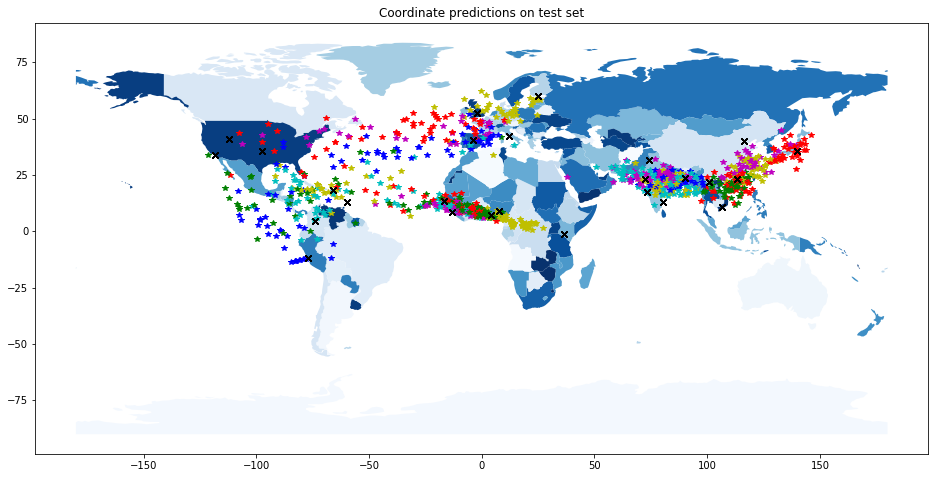

In [62]:
# generate map with ground truth labels and predictions color coded by ground truth labels
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(column='name', cmap='Blues', figsize=(16,8))
# plot predictions
for i in range(len(Y_pred[:,1])):
    if (Y_test[i,0] == 26.0 and Y_test[i,1] == 64.0):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'r*')
    elif (math.isclose(Y_test[i,0], 35.483, abs_tol=0.05) and math.isclose(Y_test[i,1], -97.53333, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'r*')
    elif (math.isclose(Y_test[i,0], 7.4, abs_tol=0.05) and math.isclose(Y_test[i,1], 3.92, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'r*')
    elif (math.isclose(Y_test[i,0], -1.27, abs_tol=0.05) and math.isclose(Y_test[i,1], 36.61, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'y*')
    elif (math.isclose(Y_test[i,0], 35.68, abs_tol=0.05) and math.isclose(Y_test[i,1], 139.68, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'r*')
    elif (math.isclose(Y_test[i,0], 22.0, abs_tol=0.05) and math.isclose(Y_test[i,1], 100.78, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'r*')
    elif (math.isclose(Y_test[i,0], 40.767, abs_tol=0.05) and math.isclose(Y_test[i,1], -111.8904, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'm*')
    elif (math.isclose(Y_test[i,0], 39.916666, abs_tol=0.05) and math.isclose(Y_test[i,1], 116.38333300000001, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'm*')
    elif (math.isclose(Y_test[i,0], 23.02, abs_tol=0.05) and math.isclose(Y_test[i,1], 72.58, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'm*')
    elif (math.isclose(Y_test[i,0], 13.09, abs_tol=0.05) and math.isclose(Y_test[i,1], 80.27, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'c*')
    elif (math.isclose(Y_test[i,0], 13.454876, abs_tol=0.05) and math.isclose(Y_test[i,1], -16.579032, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'c*')
    elif (Y_test[i,0] == 42.1 and Y_train[i,1] == 12.0): 
        base.plot(Y_pred[i,1], Y_pred[i,0], 'c*')
    elif (math.isclose(Y_test[i,0], 31.554606, abs_tol=0.05) and math.isclose(Y_test[i,1], 74.357158, abs_tol=0.05)): 
        base.plot(Y_pred[i,1], Y_pred[i,0], 'c*')
    elif (math.isclose(Y_test[i,0], 4.58333, abs_tol=0.05) and math.isclose(Y_test[i,1], -74.066666, abs_tol=0.05)): 
        base.plot(Y_pred[i,1], Y_pred[i,0], 'c*')
    elif (math.isclose(Y_test[i,0], 60.17, abs_tol=0.05) and math.isclose(Y_test[i,1], 24.93, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'y*')
    elif (math.isclose(Y_test[i,0], 23.7, abs_tol=0.05) and math.isclose(Y_test[i,1], 90.35, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'b*')
    elif (math.isclose(Y_test[i,0], 8.48, abs_tol=0.05) and math.isclose(Y_test[i,1], -13.23, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'm*')
    elif (math.isclose(Y_test[i,0], 40.38, abs_tol=0.05) and math.isclose(Y_test[i,1], -3.72, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'b*')
    elif (math.isclose(Y_test[i,0], 9.06666, abs_tol=0.05) and math.isclose(Y_test[i,1], 7.483333, abs_tol=0.05)): 
        base.plot(Y_pred[i,1], Y_pred[i,0], 'g*')
    elif (math.isclose(Y_test[i,0], 34.0544, abs_tol=0.05) and math.isclose(Y_test[i,1], -118.2439, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'g*')
    elif (math.isclose(Y_test[i,0], 10.78, abs_tol=0.05) and math.isclose(Y_test[i,1], 106.68, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'g*')
    elif (math.isclose(Y_test[i,0], 13.1, abs_tol=0.05) and math.isclose(Y_test[i,1], -59.62, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'g*')
    elif (math.isclose(Y_test[i,0], -12.04, abs_tol=0.05) and math.isclose(Y_test[i,1], -77.03, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'b*')
    elif (math.isclose(Y_test[i,0], 23.133329999999997, abs_tol=0.05) and math.isclose(Y_test[i,1], 113.266667, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'y*')
    elif (Y_test[i,0] == 18.4 and Y_test[i,1] == -66.1):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'y*')
    elif (math.isclose(Y_test[i,0], 17.37, abs_tol=0.05) and math.isclose(Y_test[i,1], 73.48, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'y*')
    elif (math.isclose(Y_test[i,0], 52.486243, abs_tol=0.05) and math.isclose(Y_test[i,1], -1.8904009999999998, abs_tol=0.05)):
        base.plot(Y_pred[i,1], Y_pred[i,0], 'r*')
# plot ground truths
base.plot(Y_test[:,1], Y_test[:,0], 'kx')
base.set_title('Coordinate predictions on test set')


In [22]:
# store model and other vital files
model2.save_weights("model2.h5")
save('Y_test.npy', Y_test)
save('X_test.npy', X_test)
save('Y_train.npy', Y_train)
save('X_train.npy', X_train)

In [ ]:
# load model and other vital files to run last few cells
model2.load_weights("model2.h5")

In [27]:
Y_test[1,:] == [13.1 , -59.62]

array([ True,  True])